# Tech Stack Vector Analysis

## Developers Profiles ranking regarding to technologies

Our model generates a list of users ranked regarding to their abilities with a list of technologies specified

   


## Most similar to:
Here, we will ask our model to find the github users most similars regarding to most iconic/used tech stacks!




## Let's see what we get for the networks's main users:

   Example of a list/vector of techs/langs =['JavaScript','JavaScript','Python','JavaScript','JavaScript','C++','JavaScript','Lua','C']

    The language words can be repeated, that way the weight can be increased for the specific tech and this can help us to find the most specialist dev.


Usaremos a estrutura de comunidades encontradas na rede de seguidores para testar se os devs rankeados estão na mesma comunidade.

In [1]:
# %%time

import pandas as pd
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.style.use('ggplot')


# from bokeh.plotting import figure, show
# from bokeh.models import Range1d, NumeralTickFormatter, FixedTicker, Legend
# from bokeh.palettes import Set1_7, RdBu5, RdBu11
# from bokeh.io import output_notebook
# output_notebook()

%matplotlib inline

from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import Word2Vec
from multiprocessing import cpu_count
from gensim.similarities import MatrixSimilarity, SparseMatrixSimilarity, SoftCosineSimilarity, SparseTermSimilarityMatrix

# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# Image(url="http://www.revistaforum.com.br/blogdorovai/wp-content/uploads/2014/01/grafico-inflacao.jpg")

# Lets get the most followed users repositories dataset

In [2]:
users_repositories = pd.read_csv('../data/recife/users__repositories.csv', dtype=str, na_values=[""])
users_repositories.head()

,User,Repo_Member,mRepo_Language,Repo_Owner,oRepo_Language
0,tarruda,libmpack/libmpack,C,"tarruda/Algoritmos,tarruda/archdb,tarruda/back...","JavaScript,JavaScript,JavaScript,JavaScript,Py..."
1,mairatma,"deprecate/steel-avatar,deprecate/steel-cell-de...","CSS,CSS,HTML,CSS,HTML,CSS,JavaScript,CSS,JavaS...","mairatma/alloy-ui,mairatma/alloyui.com,mairatm...","JavaScript,JavaScript,TypeScript,JavaScript,Ja..."
2,joselitojunior1,"acmh/maecoruja,Cisneiros/projeto-anfa,demianbo...","JavaScript,Java,Java,HTML,JavaScript,None","joselitojunior1/abigobaldo-nunes-adventures,jo...","JavaScript,HTML,CSS,None,None,None,None,GCC Ma..."
3,marcelcaraciolo,"irgmedeiros/TCCRecommender,jg1141/Open-Allure-DS","Python,Python","marcelcaraciolo/apontador-api-libs,marcelcarac...","PHP,Python,Python,None,Python,Python,Python,No..."
4,luanfonceca,"andrezap/analise_expressao_genica,andrezap/arv...","Java,Java,Java,Ruby,Ruby,JavaScript,JavaScript...","luanfonceca/168horas,luanfonceca/4stoq,luanfon...","CSS,Ruby,Python,JavaScript,Python,Python,None,..."


In [3]:

users_repositories.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User            1992 non-null   object
 1   Repo_Member     785 non-null    object
 2   mRepo_Language  733 non-null    object
 3   Repo_Owner      1630 non-null   object
 4   oRepo_Language  1498 non-null   object
dtypes: object(5)
memory usage: 77.9+ KB


In [4]:
users_repositories.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 688 entries, 0 to 1990
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User            688 non-null    object
 1   Repo_Member     688 non-null    object
 2   mRepo_Language  688 non-null    object
 3   Repo_Owner      688 non-null    object
 4   oRepo_Language  688 non-null    object
dtypes: object(5)
memory usage: 32.2+ KB


In [5]:
users_repositories['Repo_Member'].apply(lambda x: list([l for l in str(x).split(',') if l!='None' and l!='']))
users_repositories.head()

,User,Repo_Member,mRepo_Language,Repo_Owner,oRepo_Language
0,tarruda,libmpack/libmpack,C,"tarruda/Algoritmos,tarruda/archdb,tarruda/back...","JavaScript,JavaScript,JavaScript,JavaScript,Py..."
1,mairatma,"deprecate/steel-avatar,deprecate/steel-cell-de...","CSS,CSS,HTML,CSS,HTML,CSS,JavaScript,CSS,JavaS...","mairatma/alloy-ui,mairatma/alloyui.com,mairatm...","JavaScript,JavaScript,TypeScript,JavaScript,Ja..."
2,joselitojunior1,"acmh/maecoruja,Cisneiros/projeto-anfa,demianbo...","JavaScript,Java,Java,HTML,JavaScript,None","joselitojunior1/abigobaldo-nunes-adventures,jo...","JavaScript,HTML,CSS,None,None,None,None,GCC Ma..."
3,marcelcaraciolo,"irgmedeiros/TCCRecommender,jg1141/Open-Allure-DS","Python,Python","marcelcaraciolo/apontador-api-libs,marcelcarac...","PHP,Python,Python,None,Python,Python,Python,No..."
4,luanfonceca,"andrezap/analise_expressao_genica,andrezap/arv...","Java,Java,Java,Ruby,Ruby,JavaScript,JavaScript...","luanfonceca/168horas,luanfonceca/4stoq,luanfon...","CSS,Ruby,Python,JavaScript,Python,Python,None,..."


In [6]:
users_repositories.describe()

,User,Repo_Member,mRepo_Language,Repo_Owner,oRepo_Language
count,1992,785,733,1630,1498
unique,1981,764,412,1622,1206
top,ViniFlira,matheusacx/Discreta,Java,"diogo-lins/BankAccount,diogo-lins/com-liferay-...","None,None"
freq,2,3,78,2,37


In [7]:
# Filtrando e Transformando o dataframe para dados de interesse (repos and langs

repos_langs = pd.DataFrame({ 
    'User': users_repositories['User'],
    'Repos': (users_repositories['Repo_Member'] +','+ users_repositories['Repo_Owner']).fillna(''),
    'Languages': (users_repositories['mRepo_Language'] +','+ users_repositories['oRepo_Language']).fillna('')})
repos_langs.head()

,User,Repos,Languages
0,tarruda,"libmpack/libmpack,tarruda/Algoritmos,tarruda/a...","C,JavaScript,JavaScript,JavaScript,JavaScript,..."
1,mairatma,"deprecate/steel-avatar,deprecate/steel-cell-de...","CSS,CSS,HTML,CSS,HTML,CSS,JavaScript,CSS,JavaS..."
2,joselitojunior1,"acmh/maecoruja,Cisneiros/projeto-anfa,demianbo...","JavaScript,Java,Java,HTML,JavaScript,None,Java..."
3,marcelcaraciolo,"irgmedeiros/TCCRecommender,jg1141/Open-Allure-...","Python,Python,PHP,Python,Python,None,Python,Py..."
4,luanfonceca,"andrezap/analise_expressao_genica,andrezap/arv...","Java,Java,Java,Ruby,Ruby,JavaScript,JavaScript..."


## Repositories

In [8]:
repos = repos_langs['Repos']\
            .apply(lambda x: str(x).split(','))\
            .apply(lambda x: [item[1] for item in [r.split('/') for r in x] if len(item) > 1])
repos

0       [libmpack, Algoritmos, archdb, backbone-deep-m...
1       [steel-avatar, steel-cell-deprecated, steel-dr...
2       [maecoruja, projeto-anfa, phonegapbootcampsite...
3       [TCCRecommender, Open-Allure-DS, apontador-api...
4       [analise_expressao_genica, arvoresLP2, Ilicita...
                              ...                        
1987                                                   []
1988                       [am, am, primeiroteste, teste]
1989                                                   []
1990    [WhereverIgo, RuralMaps, RuralMaps-Actionbar, ...
1991                                                   []
Name: Repos, Length: 1992, dtype: object

### Languages

In [9]:
# Selecao de caracteristicas: vetor de linguagens
languages = repos_langs['Languages'].apply(lambda x: list([l for l in str(x).split(',') if l!='None' and l!='']))
languages.head()

0    [C, JavaScript, JavaScript, JavaScript, JavaSc...
1    [CSS, CSS, HTML, CSS, HTML, CSS, JavaScript, C...
2    [JavaScript, Java, Java, HTML, JavaScript, Jav...
3    [Python, Python, PHP, Python, Python, Python, ...
4    [Java, Java, Java, Ruby, Ruby, JavaScript, Jav...
Name: Languages, dtype: object

# Distribuicao de tecnologias unicas/com repeticao

In [10]:


repo_langs_df = pd.DataFrame({
 'User': users_repositories['User'],
 'Langs_List': languages,
 'Langs_Count': languages.apply(len),
 'Langs_Count_Unique': languages.apply(set).apply(len),
    
 'Repos_List': repos,
 'Repos_Count': repos.apply(len),
 'Repos_Count_Unique': repos.apply(set).apply(len)
})

repo_langs_df.describe()


,Langs_Count,Langs_Count_Unique,Repos_Count,Repos_Count_Unique
count,1992.000000,1992.000000,1992.000000,1992.000000
mean,5.681225,1.745984,6.834337,6.453815
std,13.456416,3.036317,15.509549,14.763458
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,6.000000,3.000000,7.000000,7.000000
max,149.000000,19.000000,161.000000,159.000000


In [11]:
repo_langs_df.iloc[:10]

,User,Langs_List,Langs_Count,Langs_Count_Unique,Repos_List,Repos_Count,Repos_Count_Unique
0,tarruda,"[C, JavaScript, JavaScript, JavaScript, JavaSc...",149,16,"[libmpack, Algoritmos, archdb, backbone-deep-m...",157,157
1,mairatma,"[CSS, CSS, HTML, CSS, HTML, CSS, JavaScript, C...",97,5,"[steel-avatar, steel-cell-deprecated, steel-dr...",101,97
2,joselitojunior1,"[JavaScript, Java, Java, HTML, JavaScript, Jav...",42,10,"[maecoruja, projeto-anfa, phonegapbootcampsite...",58,57
3,marcelcaraciolo,"[Python, Python, PHP, Python, Python, Python, ...",35,9,"[TCCRecommender, Open-Allure-DS, apontador-api...",43,43
4,luanfonceca,"[Java, Java, Java, Ruby, Ruby, JavaScript, Jav...",103,7,"[analise_expressao_genica, arvoresLP2, Ilicita...",123,123
5,deividazevedo2,"[Java, Java, Java, HTML, PHP, HTML, Java, Java...",14,5,"[Scream, HumQueCaro, ProjetoHumQueCaro, Projet...",22,18
6,gileno,"[Jupyter Notebook, Python, Python, Python, Jup...",58,7,"[Analise_de_Dados_de_Redes_Sociais_com_Python,...",69,69
7,simoneas02,"[JavaScript, Java, PHP, Ruby, JavaScript, Java...",24,8,"[css-grid-layout-manual, por-dentro-do-github,...",42,41
8,filipeximenes,"[Python, HTML, HTML, JavaScript, Matlab, Pytho...",44,9,"[pocket, django-apps-checklist, agendacultural...",45,45
9,renatooliveira,"[Python, Python, JavaScript, JavaScript, JavaS...",31,6,"[coinpricemonitor, TODO-list-single-page-appli...",36,33


In [12]:
repo_langs_df.sort_values(ascending=False, by="Langs_Count_Unique")[0:100]

,User,Langs_List,Langs_Count,Langs_Count_Unique,Repos_List,Repos_Count,Repos_Count_Unique
30,pcstl,"[CSS, Processing, Python, C#, Objective-C, Pyt...",41,19,"[analisecandidatos, hackathonmj, triangle_visu...",45,44
484,lgallindo,"[CSS, R, R, R, R, R, C, R, HTML, Shell, Python...",75,18,"[MapaExpo2016, CosW, SecKW, SinIW, TanB, abjDa...",84,84
101,itsmealves,"[Python, JavaScript, Java, Vim script, CSS, Ja...",54,17,"[Django_eh_massa, SINS-WEB, DI_progs, .vim, 20...",62,62
82,yelken,"[PHP, CSS, Arduino, Python, Objective-C, HTML,...",62,17,"[startuppe-representmap, academiadacidade, Sky...",99,99
0,tarruda,"[C, JavaScript, JavaScript, JavaScript, JavaSc...",149,16,"[libmpack, Algoritmos, archdb, backbone-deep-m...",157,157
...,...,...,...,...,...,...,...
218,pernambucano,"[Python, Python, Python, Jupyter Notebook, Jav...",33,8,"[MineracaoWeb, webproject, BDs-Inteligentes-Pr...",39,39
1031,carlossilvamelo,"[Java, HTML, Assembly, CSS, Java, Java, HTML, ...",19,8,"[projetoPDS, 2UD, arqsoft, bancodados, bootLoa...",24,24
128,TigerRobocop,"[Java, Python, CSS, Kotlin, Java, Java, Java, ...",44,8,"[hackmobile-tw, 30-Days-of-Python, Andre-Portf...",44,44
130,gabrieldluca,"[JavaScript, HTML, Python, Swift, Python, Swif...",11,8,"[Culturally, FSI_Apresentacao, bird-migration,...",11,11


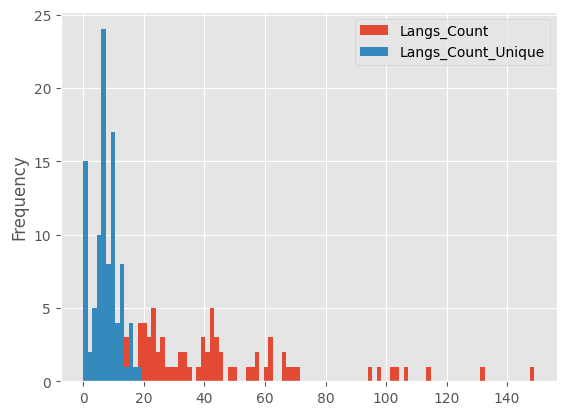

In [23]:
repo_langs_df[['Langs_Count', 'Langs_Count_Unique']][:100].plot.hist(bins=100);

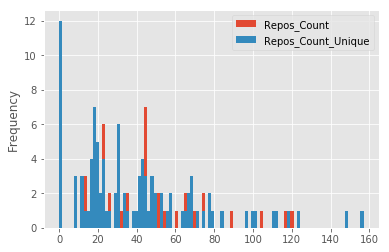

In [14]:
repo_langs_df[['Repos_Count', 'Repos_Count_Unique']][:100].plot.hist(bins=100);

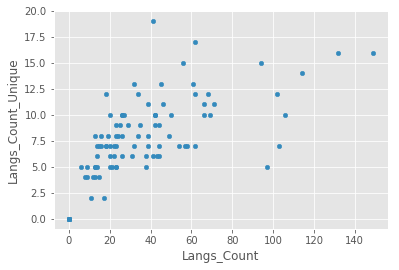

In [15]:
# Qtd pessoas x qtd de tecnologias unicas
repo_langs_df[:100].plot.scatter(x="Langs_Count", y="Langs_Count_Unique");

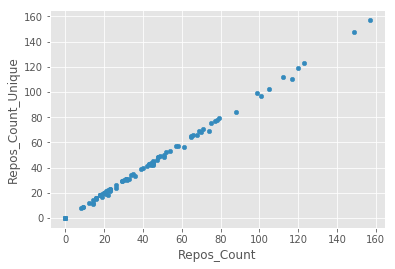

In [16]:
repo_langs_df[:100].plot.scatter(x="Repos_Count", y="Repos_Count_Unique");

In [17]:
repo_langs_df.Langs_Count.unique()

array([149,  97,  42,  35, 103,  14,  58,  24,  44,  31,  46,   0,  26,
       132, 102,  34,  62,  66,  41,  16,  22,  15,  38,  43,  21, 114,
        54,  71,  19,  17,  23,  29,  32,  68,  20,  11,  18,  50, 106,
        45,  13,  27,  56,  39,  57,   9,   6,  94,  25,  61,  69,   8,
        12,  49,  36,  33,  47,  28,   7,   4,  48,  40,   3,  81,   5,
        10,  60, 145,   2,  30,   1,  75,  79,  96,  84])

In [18]:
repo_langs_df.Repos_Count.unique()

array([157, 101,  58,  43, 123,  22,  69,  42,  45,  36,  57,   0,  31,
       149, 117,  39,  71,  77,  44,  52,  18,  23,  21, 120,  49,  61,
        74,  70,  88,  19,  48,  33,  78,  65,  14,  40,  47,  66, 112,
        35,  51,  29,  34,  54,  30,  68,   9,  16, 105,  26,  20,  99,
        75,  32,  79,   8,  12,  62,  25,  17,  11,  24,  55,  59,  10,
         4,  50,   3,  84,   6,  13,  28,  27,  60,  15, 161,   5,   7,
        38,  37,  41,   2,  85, 114, 104, 102])

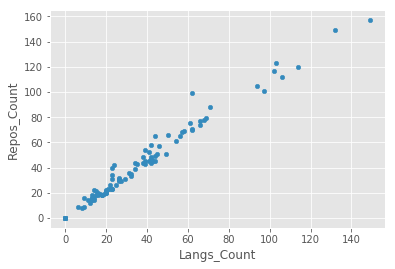

In [19]:
repo_langs_df[:100].plot.scatter(x="Langs_Count", y="Repos_Count");

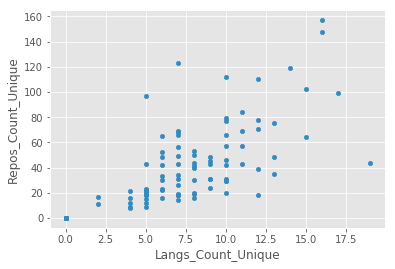

In [20]:
repo_langs_df[:100].plot.scatter(x="Langs_Count_Unique", y="Repos_Count_Unique");

# Recommendation: Building terms dictionaries: Repos and Languages

## Repos Terms

In [14]:
#  building langs dictionary
repos_dictionary = Dictionary(repos)

print("Number of unique words: %d" % len(repos_dictionary))
print(repos_dictionary)

Number of unique words: 10826
Dictionary<10826 unique tokens: ['Algoritmos', 'CodeMirror', 'DefinitelyTyped', 'MaidSafe', 'MemoryModule']...>


In [15]:
repo_terms_dict = repos_dictionary.token2id

repo_terms_pairs = [(k, v) for (k, v) in repo_terms_dict.items()]

print(repo_terms_pairs[:20])

[('Algoritmos', 0), ('CodeMirror', 1), ('DefinitelyTyped', 2), ('MaidSafe', 3), ('MemoryModule', 4), ('URLON', 5), ('VBoxTrayIcon', 6), ('YouCompleteMe', 7), ('archdb', 8), ('backbone-deep-model', 9), ('backbone-jquerymobile', 10), ('beets', 11), ('better-sqlite3', 12), ('bootstrap-datetimepicker', 13), ('brightray', 14), ('buffer-prefix-range', 15), ('busted', 16), ('check', 17), ('classic', 18), ('closure-externs', 19)]


In [16]:
repo_terms = repo_terms_dict.keys()
print(list(repo_terms)[:7])

['Algoritmos', 'CodeMirror', 'DefinitelyTyped', 'MaidSafe', 'MemoryModule', 'URLON', 'VBoxTrayIcon']


In [17]:
repo_terms_freq = repo_terms_dict.values()
print(list(repo_terms_freq)[:7])

[0, 1, 2, 3, 4, 5, 6]


## Languages Terms

In [18]:
#  building dictionary based on languages dataset
langs_dictionary = Dictionary(languages)
print("Number of unique words: %d" % len(langs_dictionary))
print(langs_dictionary)


Number of unique words: 99
Dictionary<99 unique tokens: ['C', 'C++', 'CMake', 'CoffeeScript', 'HTML']...>


In [19]:
# Com o dicionario de tokens é possivel criar um dataframe com os valores do tf-idf de linguagens pra cada usuario
lang_terms_dict = langs_dictionary.token2id

lang_terms_pairs = [(k, v) for (k, v) in lang_terms_dict.items()]

print(lang_terms_pairs[:20])

[('C', 0), ('C++', 1), ('CMake', 2), ('CoffeeScript', 3), ('HTML', 4), ('Haskell', 5), ('Java', 6), ('JavaScript', 7), ('Lua', 8), ('Makefile', 9), ('Perl', 10), ('Python', 11), ('Ruby', 12), ('Shell', 13), ('TypeScript', 14), ('VimL', 15), ('CSS', 16), ('GCC Machine Description', 17), ('Go', 18), ('PHP', 19)]


## Features: TF-IDF (TermFrequency-InverseDocumentFrequency)

Iremos aplicar o modelo de tf-idf, já que queremos dar foco no peso da tecnologia por pessoa (frequencia que a tecnologia aparece) tendo em vista que que a ocorrencia da tecnologia não é muito comum entre todos os usuários. 

Metricas do github: Users by Languages
* [373   Java](https://github.com/search?l=Java&q=location%3ARecife&type=Users )
* [256   JavaScript](https://github.com/search?l=JavaScript&q=location%3ARecife&type=Users )
* [165 Python](https://github.com/search?l=Python&q=location%3ARecife&type=Users )
* [126 HTML](https://github.com/search?l=HTML&q=location%3ARecife&type=Users )
* [103 PHP](https://github.com/search?l=PHP&q=location%3ARecife&type=Users )
* [77 Ruby](https://github.com/search?l=Ruby&q=location%3ARecife&type=Users )
* [72 CSS](https://github.com/search?l=CSS&q=location%3ARecife&type=Users )
* [54 C](https://github.com/search?l=C&q=location%3ARecife&type=Users )
* [41 C++](https://github.com/search?l=C%2B%2B&q=location%3ARecife&type=Users )
* [39 C#](https://github.com/search?l=C%23&q=location%3ARecife&type=Users)

O idf é necesario para normalizar os valores.

Na análise abaixo podemos checar a nossa hipótese

In [22]:
# Traing Model for predicions(similaridade): tf-idf\
tfidf = TfidfModel(dictionary=lang_terms_dict)
tfidf

AttributeError: 'dict' object has no attribute 'num_docs'

## lang_terms_dict

In [21]:
lang_terms_list = list(lang_terms_dict)
lang_terms_list[:10]

['C',
 'C++',
 'CMake',
 'CoffeeScript',
 'HTML',
 'Haskell',
 'Java',
 'JavaScript',
 'Lua',
 'Makefile']

## ** Verificando hipotese: new_doc é nosso alvo **

Vamos configurar um novo conjunto de techs(new_doc) para encontrar usuarios compatíveis.


In [94]:
# Novo Dado a ser rankeado
new_doc = ['JavaScript','JavaScript','Python','JavaScript','JavaScript','C++','JavaScript','Lua','C'] # novo exemplo

# Transformando novo exemplo em vetor de (TF) legend = (lang_nr, freq)
new_vec = dictionary.doc2bow(new_doc) # term frequency vector
new_vec

[(0, 1), (1, 1), (7, 5), (8, 1), (11, 1)]

In [95]:
# É facil ver que o valor estimado para o termo 7=Javascript é maior

new_vec_tfidf = tfidf[new_vec] # Valor do tfidf pra cada termo em new_vec
new_vec_tfidf

[(0, 0.25642150351992826),
 (1, 0.2662231783141811),
 (7, 0.7677013457090224),
 (8, 0.4890197974947278),
 (11, 0.1867284480620099)]

In [96]:
keys, values = zip(*new_vec)
freq_vector = pd.DataFrame([values],columns=[(lang_terms_list[idx]) for idx in keys])
freq_vector 

,C,C++,JavaScript,Lua,Python
0,1,1,5,1,1


In [97]:
# Codificamos assim cada usuario pra seu vetor tf->
# Transforming dataset values
# vetor de frequencia de palavras = techs freq

bow_corpus = [dictionary.doc2bow(text) for text in languages] # frequency vector for all languages dataset
bow_corpus[:2]

[[(0, 11),
  (1, 13),
  (2, 1),
  (3, 13),
  (4, 2),
  (5, 1),
  (6, 3),
  (7, 67),
  (8, 5),
  (9, 1),
  (10, 1),
  (11, 14),
  (12, 3),
  (13, 4),
  (14, 2),
  (15, 8)],
 [(4, 7), (6, 1), (7, 81), (14, 2), (16, 6)]]

In [98]:
# Cria dataframe com o freq-terms

repo_langs_df['Lang_corpus'] = repo_langs_df['Langs_List'] \
                                .apply(dictionary.doc2bow)\
                                .apply(lambda x: sorted(x, key=lambda lang_term: lang_term[1], reverse=True))

repo_langs_df['Lang_corpus_df'] = repo_langs_df['Lang_corpus'] \
                                    .apply(lambda x: list(zip(*x))) \
                                    .apply(lambda x: pd.DataFrame() if len(x)<2 else pd.DataFrame([x[1]],
                                                                                      columns=[lang_terms_list[idx] for idx in x[0]]))
# pd.EmptyDataFrame()

repo_langs_df.head()

,User,Langs_List,Langs_Count,Langs_Count_Unique,Repos_List,Repos_Count,Repos_Count_Unique,Lang_corpus,Lang_corpus_df
0,tarruda,"[C, JavaScript, JavaScript, JavaScript, JavaSc...",149,16,"[libmpack, Algoritmos, archdb, backbone-deep-m...",157,157,"[(7, 67), (11, 14), (1, 13), (3, 13), (0, 11),...",JavaScript Python C++ CoffeeScript C ...
1,mairatma,"[CSS, CSS, HTML, CSS, HTML, CSS, JavaScript, C...",97,5,"[steel-avatar, steel-cell-deprecated, steel-dr...",101,97,"[(7, 81), (4, 7), (16, 6), (14, 2), (6, 1)]",JavaScript HTML CSS TypeScript Java 0 ...
2,joselitojunior1,"[JavaScript, Java, Java, HTML, JavaScript, Jav...",42,10,"[maecoruja, projeto-anfa, phonegapbootcampsite...",58,57,"[(4, 13), (7, 13), (16, 4), (6, 3), (19, 3), (...",HTML JavaScript CSS Java PHP TypeScrip...
3,marcelcaraciolo,"[Python, Python, PHP, Python, Python, Python, ...",35,9,"[TCCRecommender, Open-Allure-DS, apontador-api...",43,43,"[(11, 27), (0, 1), (7, 1), (10, 1), (12, 1), (...",Python C JavaScript Perl Ruby Shell C...
4,luanfonceca,"[Java, Java, Java, Ruby, Ruby, JavaScript, Jav...",103,7,"[analise_expressao_genica, arvoresLP2, Ilicita...",123,123,"[(11, 55), (7, 25), (16, 9), (12, 6), (6, 5), ...",Python JavaScript CSS Ruby Java HTML ...


In [99]:
# [langs_df.bow_corpus_df.iloc[tr[0]].plot.bar() for tr in top_recs_soft[:5]]
# .plot.bar()
# languages_frequency
repo_langs_df.Lang_corpus_df.iloc[2].iloc[0].keys()[0]

'HTML'

## Modelo para predição Similaridade de cosseno

Para encontrar perfis transversais tentamos usar o modelo Similaridade de cosseno.

Cosine similarity ou Similaridade de cosseno ou Semelhança de cosseno

A semelhança de cosseno é uma medida de similaridade(ou distância) entre dois vetores não nulos de um espaço de produto interno que mede o cosseno do ângulo entre eles. O cosseno de 0° é 1, e é menor que 1 para qualquer outro ângulo no intervalo [0,0.5π), portanto, um julgamento de orientação e não magnitude: dois vetores com a mesma orientação têm uma semelhança de cosseno de 1, dois vetores orientados a 90° um em relação ao outro têm uma semelhança de 0, e dois vetores diametralmente opostos têm uma semelhança de -1, independente de sua magnitude. A semelhança de cosseno é particularmente usada no espaço positivo, onde o resultado é nitidamente limitado em {\ displaystyle [0,1]} [0,1]. O nome deriva do termo "direção cosseno": neste caso, os vetores unitários são maximamente "similares" se forem paralelos e maximamente "dissimilares" se forem ortogonais (perpendiculares). Isso é análogo ao cosseno, que é a unidade (valor máximo) quando os segmentos subtendem um ângulo zero e zero (não correlacionado) quando os segmentos são perpendiculares.

[From Wikipedia, the free encyclopedia](https://en.wikipedia.org/wiki/Cosine_similarity)

In [100]:
# Model: Calculo de similaridade om Cosin

index = SparseMatrixSimilarity(tfidf[bow_corpus], num_features=102)

# LISTA DE TOP 10 USUARIOS RECOMENDADOS PARA NEW_DOC

In [101]:
similarities = index[tfidf[new_vec]]
recomendations = list(enumerate(similarities))
top_recs = sorted(recomendations, key=lambda rating: rating[1], reverse=True)
repos_langs.iloc[[tr[0] for tr in top_recs[:10]]]

,User,Repos,Languages
638,AleffSouza,"ahlp/owls_server,rafaellsma/transfer,renatohlf...","JavaScript,Java,JavaScript,JavaScript,C,Python..."
0,tarruda,"libmpack/libmpack,tarruda/Algoritmos,tarruda/a...","C,JavaScript,JavaScript,JavaScript,JavaScript,..."
1075,reueljonathan,"ahlp/owls_server,reueljonathan/functions-game,...","JavaScript,JavaScript,Lua,JavaScript,Lua,JavaS..."
580,felipemobile,"Colubris/parse-dashboard,felipemobile/awesome-...","JavaScript,HTML,C,JavaScript,JavaScript,JavaSc..."
992,marcuscarneiro,"raony/Iluminare2,marcuscarneiro/colabgame,marc...","Python,None,JavaScript,JavaScript,JavaScript,J..."
197,leoreinaux,"clausiobarbosa/python-keccak_hash,hiagors92/hi...","C,JavaScript,None,Python,C++,Python,Python,Jav..."
160,acmh,"fpwanderley/projetobd,mmfrb/siscom,rodrigoalve...","Python,Python,JavaScript,JavaScript,CSS,HTML,C..."
133,FranciscoMarinho,"karlafalcao/astar-search,karlafalcao/crie-awe-...","JavaScript,JavaScript,JavaScript,JavaScript"
1423,bureauworks,"bureauworks/mdPickers,bureauworks/slate,bureau...","JavaScript,JavaScript,JavaScript,JavaScript"
1457,FEMUGPE,"FEMUGPE/femug-lottery,FEMUGPE/FEMUGPE,FEMUGPE/...","JavaScript,None,JavaScript,None,JavaScript,Non..."


In [102]:
top_recs[0]


(638, 0.8798249)

[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]

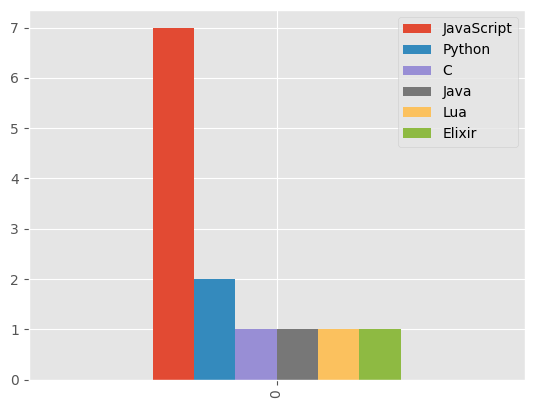

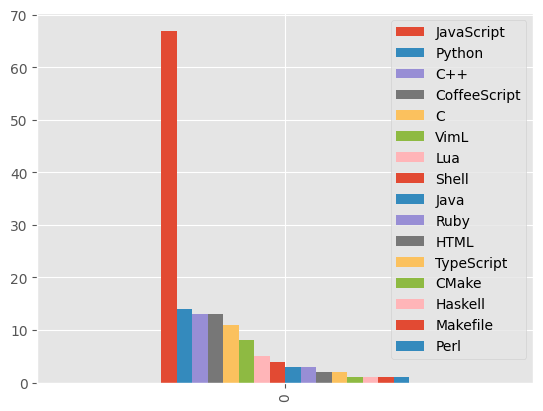

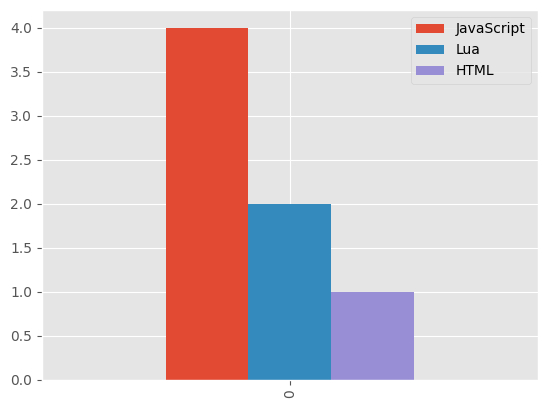

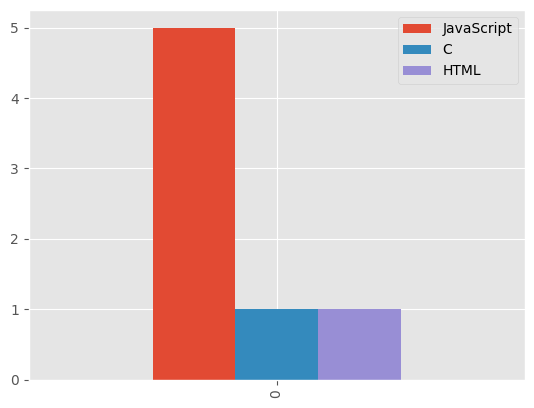

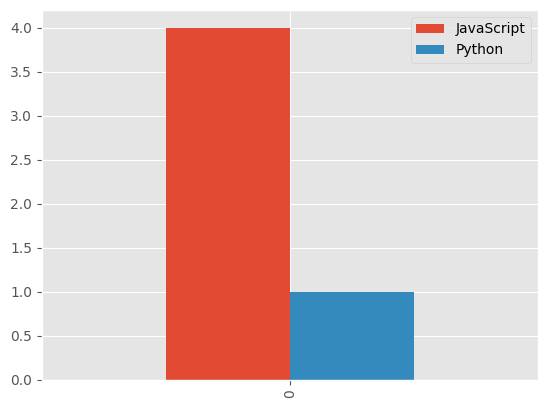

In [103]:
# Plotting the 5 top reccomendations

# langs_df.bow_corpus_df.iloc[top_recs[0][0]].plot.bar()
# langs_df.bow_corpus_df.iloc[top_recs[1][0]].plot.bar()
# langs_df.bow_corpus_df.iloc[top_recs[2][0]].plot.bar()
# langs_df.bow_corpus_df.iloc[top_recs[3][0]].plot.bar()
# langs_df.bow_corpus_df.iloc[top_recs[4][0]].plot.bar()

[repo_langs_df.Lang_corpus_df.iloc[tr[0]].plot.bar() for tr in top_recs[:5]]

#End.

## Extra: Resultados com o Algoritmo sofcosin

In [104]:
# Algoritmo: Calculo de similaridade com SofCosin

# Train a Word2Vec model.
w2v_model = Word2Vec(languages, workers=cpu_count(), vector_size=102, seed=12345)
# w2v_model = Word2Vec(languages, workers=cpu_count(), vector_size=102, seed=12345)
# #w2v_model.save("word2vec.model")

# similarity_matrix = w2v_model.wv.similarity_matrix(dictionary, tfidf, nonzero_limit=100)

# index = SoftCosineSimilarity( tfidf[bow_corpus], similarity_matrix)


In [3]:
# Initialize SoftCosineSimilarity and compute the similarity matrix.
similarity_matrix = SparseTermSimilarityMatrix(tfidf,dictionary)


NameError: name 'tfidf' is not defined

In [4]:

# Compute soft cosine similarity index.
index = SoftCosineSimilarity(tfidf[bow_corpus], similarity_matrix)
#index = SoftCosineSimilarity( tfidf[bow_corpus], similarity_matrix)

NameError: name 'tfidf' is not defined

In [81]:
similarities = index[tfidf[new_vec]]
recs_soft = list(enumerate(similarities))
print(recs_soft[:20])

[(0, 0.8191004), (1, 0.7594308), (2, 0.4366601), (3, 0.21985255), (4, 0.43278128), (5, 0.10964072), (6, 0.23319823), (7, 0.6837896), (8, 0.2423055), (9, 0.44932103), (10, 0.57785296), (11, 0.0), (12, 0.07473613), (13, 0.44912738), (14, 0.71296805), (15, 0.5911644), (16, 0.4280387), (17, 0.14004889), (18, 0.27016535), (19, 0.2393409)]


In [39]:
top_recs_soft = sorted(recs_soft, key=lambda rating: rating[1], reverse=True)
repos_langs.iloc[[tr[0] for tr in top_recs_soft[:10]]]

,Languages,Repos,User
638,"JavaScript,Java,JavaScript,JavaScript,C,Python...","ahlp/owls_server,rafaellsma/transfer,renatohlf...",AleffSouza
146,"Python,Python,None,Java,JavaScript,JavaScript,...","danisteps/Machine-Learning-Project,lucasns/pro...",foolOnTheHill
457,"JavaScript,JavaScript,Matlab,JavaScript,JavaSc...","acmh/gymquery,acmh/maecoruja,luisdelgado/Detec...",ntocampos
197,"C,JavaScript,None,Python,C++,Python,Python,Jav...","clausiobarbosa/python-keccak_hash,hiagors92/hi...",leoreinaux
160,"Python,Python,JavaScript,JavaScript,CSS,HTML,C...","fpwanderley/projetobd,mmfrb/siscom,rodrigoalve...",acmh
0,"C,JavaScript,JavaScript,JavaScript,JavaScript,...","libmpack/libmpack,tarruda/Algoritmos,tarruda/a...",tarruda
554,"None,PHP,None,Python,JavaScript,None,None,TeX,...","fss6/esd,tisstech/bootstrap-laravel-scaffold,d...",danilosoares
373,"JavaScript,Python,JavaScript,C#,PHP,JavaScript","FranciscoGileno/planning-poker,lpmourato/music...",tpmarcs
1075,"JavaScript,JavaScript,Lua,JavaScript,Lua,JavaS...","ahlp/owls_server,reueljonathan/functions-game,...",reueljonathan
105,"Java,JavaScript,JavaScript,JavaScript,JavaScri...","gfreivasc/uMQTT,casevictor/alloy,casevictor/al...",casevictor


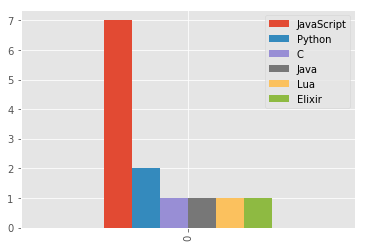

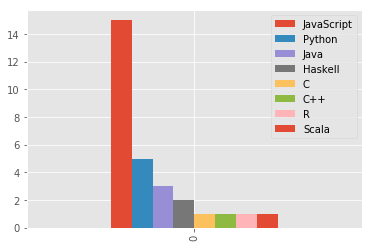

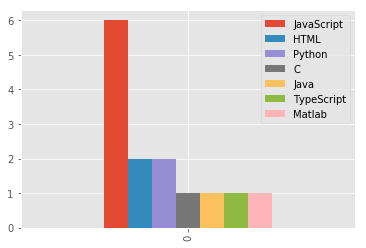

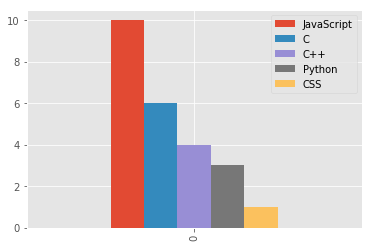

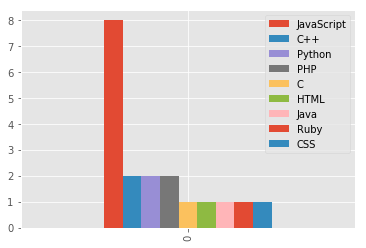

In [40]:
[repo_langs_df.Lang_corpus_df.iloc[tr[0]].plot.bar() for tr in top_recs_soft[:5]]

## Comunidades

In [51]:
communities = pd.read_csv('../data/recife/communities.csv')
communities.head()

,User,fill
0,henriquemenezes,#df89ff
1,tarruda,#4c463e
2,paulolieuthier,#73c000
3,meiralins,#df89ff
4,dapine,#4c463e


In [52]:
repo_langs_df.head()

,User,Langs_List,Langs_Count,Langs_Count_Unique,Repos_List,Repos_Count,Repos_Count_Unique
0,tarruda,"[C, JavaScript, JavaScript, JavaScript, JavaSc...",149,16,"[libmpack, Algoritmos, archdb, backbone-deep-m...",157,157
1,mairatma,"[CSS, CSS, HTML, CSS, HTML, CSS, JavaScript, C...",97,5,"[steel-avatar, steel-cell-deprecated, steel-dr...",101,97
2,joselitojunior1,"[JavaScript, Java, Java, HTML, JavaScript, Jav...",42,10,"[maecoruja, projeto-anfa, phonegapbootcampsite...",58,57
3,marcelcaraciolo,"[Python, Python, PHP, Python, Python, Python, ...",35,9,"[TCCRecommender, Open-Allure-DS, apontador-api...",43,43
4,luanfonceca,"[Java, Java, Java, Ruby, Ruby, JavaScript, Jav...",103,7,"[analise_expressao_genica, arvoresLP2, Ilicita...",123,123


In [53]:
merged_data = communities.merge(right=repo_langs_df, on='User')

In [54]:
merged_data.head()

,User,fill,Langs_List,Langs_Count,Langs_Count_Unique,Repos_List,Repos_Count,Repos_Count_Unique
0,henriquemenezes,#df89ff,"[Go, Go, Python, Python, C++, Ruby, Java, Ruby...",23,9,"[gin-example-api, android-open-source-apps, an...",31,31
1,tarruda,#4c463e,"[C, JavaScript, JavaScript, JavaScript, JavaSc...",149,16,"[libmpack, Algoritmos, archdb, backbone-deep-m...",157,157
2,paulolieuthier,#73c000,"[Java, HTML, JavaScript, Java, Go, C++, C++, P...",18,12,"[PCD_Middleware, criterion, meucongressonacion...",18,18
3,meiralins,#df89ff,"[Matlab, JavaScript, Python, Python, Python, P...",23,5,"[aprendizagem, clipboard.js, cookiecutter-tapi...",25,25
4,dapine,#4c463e,[],0,0,[],0,0


In [55]:
merged_data.sort_values('fill', axis=0, ascending=True, inplace=True)
merged_data.head()

,User,fill,Langs_List,Langs_Count,Langs_Count_Unique,Repos_List,Repos_Count,Repos_Count_Unique
158,Leviterus,#00bd94,"[CSS, JavaScript, VHDL, C++, HTML, CSS, JavaSc...",9,6,"[EudoClub, CodeCup-Cerberos, AutoSegeManager, ...",11,11
178,lucasbiagini,#00bd94,"[PHP, Cucumber, Java, HTML, Ruby, JavaScript, ...",17,7,"[siena-iat-2016, redu-specs, ShowUp, jenhogan....",17,16
305,acmh,#00bd94,"[Python, Python, JavaScript, JavaScript, CSS, ...",19,9,"[projetobd, siscom, vestibuleiro, iotflows-lan...",22,22
369,pnasc,#00bd94,[],0,0,[],0,0
274,AbrantesMar,#00bd94,[],0,0,[],0,0


In [57]:
print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#df89ff'][:20] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#4c463e'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#73c000'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#ff5584'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#00c4ff'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#00bd94'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#c0c0c0'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#ff8805'] )
# print( merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#d3b3b0'] )

KeyError: "['fill', 'Lang_corpus_df'] not in index"

In [212]:
# pink group
new_data = merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#df89ff'].reset_index().drop('index', axis=1)
new_data

,User,fill,Lang_corpus_df
0,irgmedeiros,#df89ff,Python Ruby JavaScript CSS Jupyter Note...
1,felipechaulet,#df89ff,Empty DataFrame Columns: [] Index: []
2,andersonresende,#df89ff,Python HTML JavaScript CSS Makefile Sh...
3,diogocaetano,#df89ff,Ruby JavaScript HTML PHP Elixir 0 3...
4,felipedemacedo,#df89ff,Empty DataFrame Columns: [] Index: []
5,rsarai,#df89ff,Python Java C# HTML JavaScript Shell ...
6,brunosan7os,#df89ff,Empty DataFrame Columns: [] Index: []
7,debscorreia,#df89ff,Python CoffeeScript JavaScript CSS 0 ...
8,MarcusDEFGH,#df89ff,Python Java 0 3 1
9,andrebuarque,#df89ff,Ruby JavaScript Shell PHP Objective-C 0...


In [214]:

# concat all dataframes in langs corpus column
langs_concat = pd.concat(list(new_data.Lang_corpus_df), axis=0, join='outer')\
                .reset_index().drop('index', axis=1)\
                .dropna(axis='columns', how='all')
langs_concat

,ANTLR,ApacheConf,Arduino,Assembly,C,C#,C++,CMake,CSS,Clojure,...,Shell,Standard ML,Swift,TeX,TypeScript,VHDL,Verilog,Vim script,VimL,XML
0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


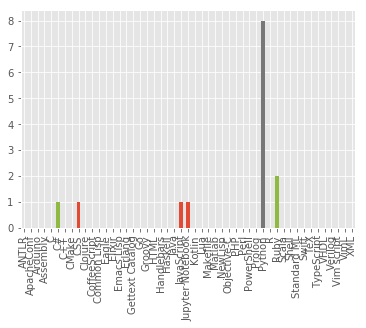

In [220]:
# plotting the first row
# langs_concat.iloc[0].plot.bar()

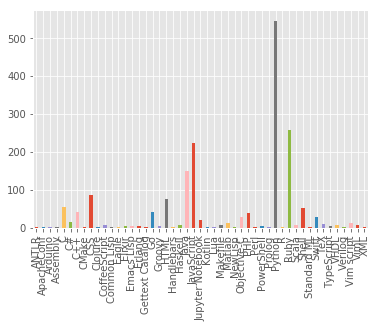

In [215]:
# Plot the sum of all rows
langs_concat.apply(np.sum, axis=0).plot.bar()

In [202]:
#00c4ff (azul)


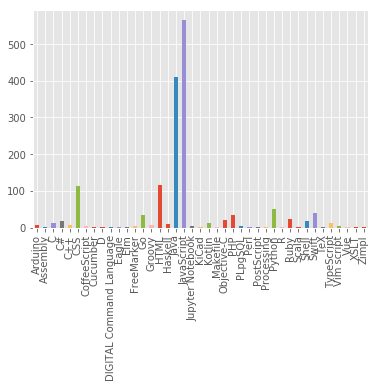

In [222]:
new_data = merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#00c4ff'].reset_index().drop('index', axis=1)

langs_concat = pd.concat(list(new_data.Lang_corpus_df), axis=0, join='outer')\
                .reset_index().drop('index', axis=1)\
                .dropna(axis='columns', how='all')
langs_concat

langs_concat.apply(np.sum, axis=0).plot.bar()

In [223]:
#73c000 (verde)


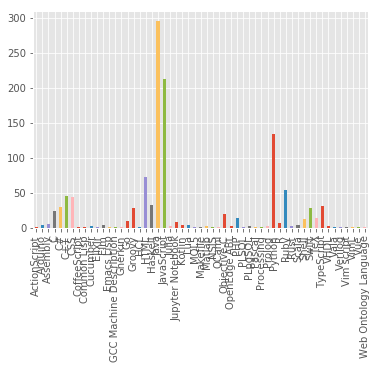

In [224]:
new_data = merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#73c000'].reset_index().drop('index', axis=1)

langs_concat = pd.concat(list(new_data.Lang_corpus_df), axis=0, join='outer')\
                .reset_index().drop('index', axis=1)\
                .dropna(axis='columns', how='all')
langs_concat

langs_concat.apply(np.sum, axis=0).plot.bar()

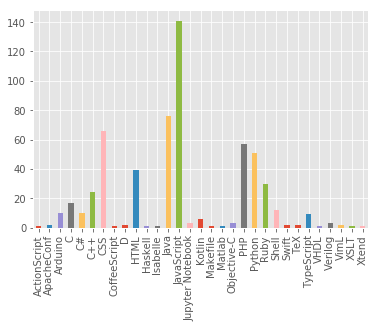

In [225]:
#ff8805 (orange)

new_data = merged_data[['User', 'fill', 'Lang_corpus_df']][merged_data.fill == '#ff8805'].reset_index().drop('index', axis=1)

langs_concat = pd.concat(list(new_data.Lang_corpus_df), axis=0, join='outer')\
                .reset_index().drop('index', axis=1)\
                .dropna(axis='columns', how='all')
langs_concat

langs_concat.apply(np.sum, axis=0).plot.bar()